In [1]:
import pandas as pd

df = pd.read_csv('covid_pca_final.csv')

In [2]:
df['interaction'] = df['liberalism'] * df['stringency_category']

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

features = ['sni_covid19_vaccination', 'new_persons_vaccinated', 'stringency_category', 'inc_death', 
            'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 
            'interaction']
target = 'inc_case'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)

y_pred = reg_tree.predict(X_test)

interaction_groups = [
    (1, 1),
    (1, 2),
    (1, 3),
    (0, 1),
    (0, 2),
    (0, 3)
]

results = {}

for liberalism, stringency in interaction_groups:
    group_mask = (X_test['liberalism'] == liberalism) & (X_test['stringency_category'] == stringency)
    X_test_group = X_test[group_mask]
    y_test_group = y_test[group_mask]
    y_pred_group = reg_tree.predict(X_test_group)

    rmse = mean_squared_error(y_test_group, y_pred_group, squared=False)
    mse = mean_squared_error(y_test_group, y_pred_group)
    bias = (y_pred_group - y_test_group).mean()
    coverage = ((y_pred_group >= y_test_group.min()) & (y_pred_group <= y_test_group.max())).mean()

    results[(liberalism, stringency)] = {
        'RMSE': rmse,
        'MSE': mse,
        'Bias': bias,
        'Coverage': coverage
    }




In [4]:

results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Liberalism', 'Stringency Category', 'RMSE', 'MSE', 'Bias', 'Coverage']
results_df['Liberalism'] = results_df['Liberalism'].map({0: 'Conservative', 1: 'Liberal'})

pd.set_option('display.float_format', lambda x: '%.3f' % x)

results_df


,Liberalism,Stringency Category,RMSE,MSE,Bias,Coverage
0,Liberal,1,22318.896,498133113.533,-544.543,0.974
1,Liberal,2,293419.633,86095080964.991,-73089.828,0.957
2,Liberal,3,106761.993,11398123173.169,45211.038,0.833
3,Conservative,1,77341.418,5981694987.033,10090.556,1.000
4,Conservative,2,52690.710,2776310913.645,24358.410,0.857
5,Conservative,3,16178.613,261747504.237,-10879.728,0.833


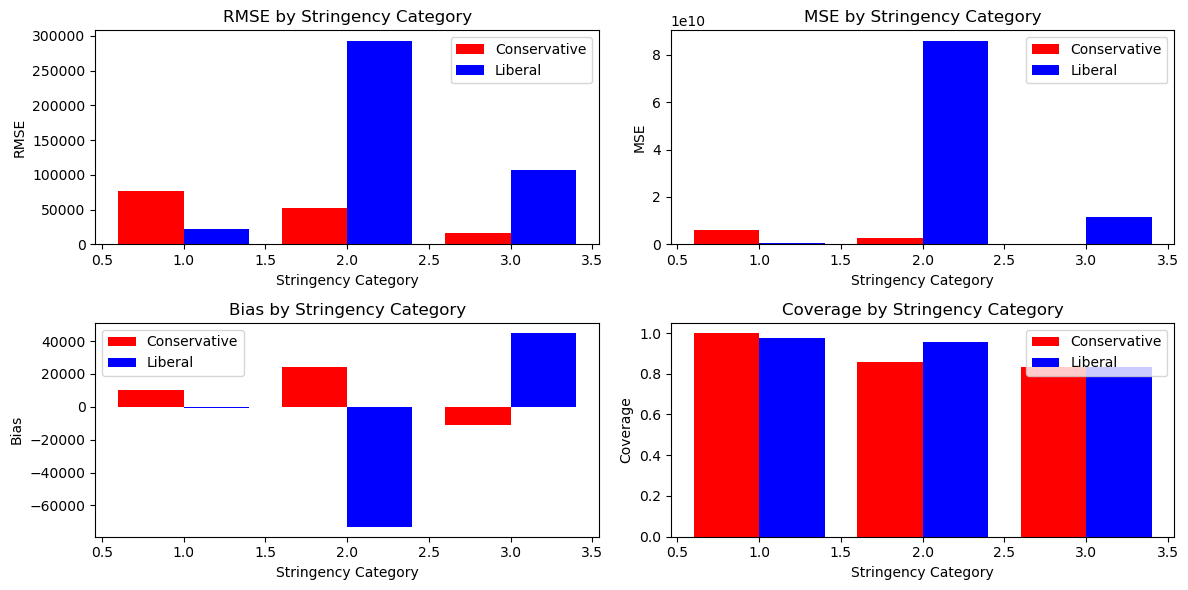

In [5]:
import matplotlib.pyplot as plt

conservative_metrics = results_df[results_df['Liberalism'] == 'Conservative']
liberal_metrics = results_df[results_df['Liberalism'] == 'Liberal']

# RMSE
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.bar(conservative_metrics['Stringency Category'] - 0.2, conservative_metrics['RMSE'], width=0.4, color='red', label='Conservative')
plt.bar(liberal_metrics['Stringency Category'] + 0.2, liberal_metrics['RMSE'], width=0.4, color='blue', label='Liberal')
plt.xlabel('Stringency Category')
plt.ylabel('RMSE')
plt.title('RMSE by Stringency Category')
plt.legend()

# MSE
plt.subplot(2, 2, 2)
plt.bar(conservative_metrics['Stringency Category'] - 0.2, conservative_metrics['MSE'], width=0.4, color='red', label='Conservative')
plt.bar(liberal_metrics['Stringency Category'] + 0.2, liberal_metrics['MSE'], width=0.4, color='blue', label='Liberal')
plt.xlabel('Stringency Category')
plt.ylabel('MSE')
plt.title('MSE by Stringency Category')
plt.legend()

# Bias
plt.subplot(2, 2, 3)
plt.bar(conservative_metrics['Stringency Category'] - 0.2, conservative_metrics['Bias'], width=0.4, color='red', label='Conservative')
plt.bar(liberal_metrics['Stringency Category'] + 0.2, liberal_metrics['Bias'], width=0.4, color='blue', label='Liberal')
plt.xlabel('Stringency Category')
plt.ylabel('Bias')
plt.title('Bias by Stringency Category')
plt.legend()

# Coverage
plt.subplot(2, 2, 4)
plt.bar(conservative_metrics['Stringency Category'] - 0.2, conservative_metrics['Coverage'], width=0.4, color='red', label='Conservative')
plt.bar(liberal_metrics['Stringency Category'] + 0.2, liberal_metrics['Coverage'], width=0.4, color='blue', label='Liberal')
plt.xlabel('Stringency Category')
plt.ylabel('Coverage')
plt.title('Coverage by Stringency Category')
plt.legend()

plt.tight_layout()
plt.show()


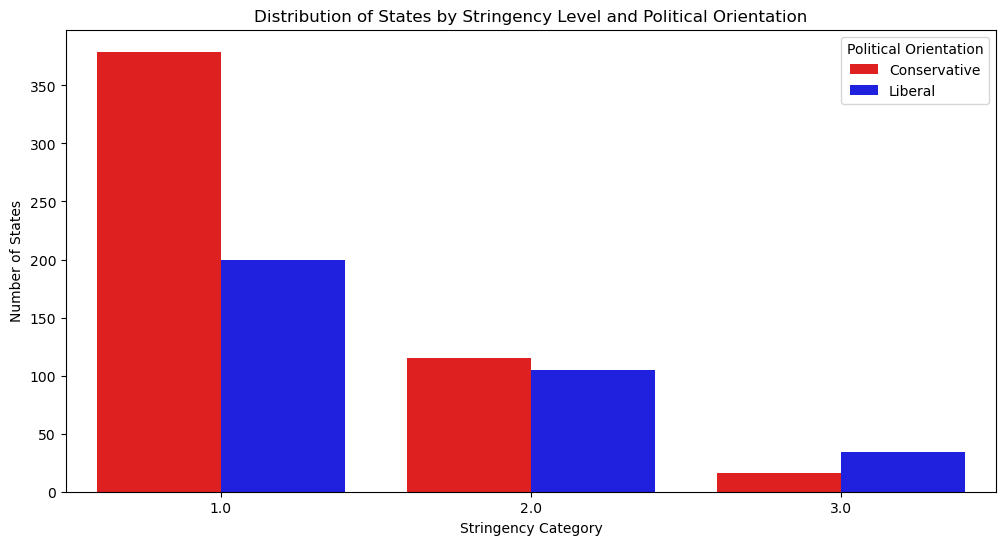

In [7]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(x='stringency_category', hue='liberalism', data=df, palette={0: 'red', 1: 'blue'})
plt.xlabel('Stringency Category')
plt.ylabel('Number of States')
plt.title('Distribution of States by Stringency Level and Political Orientation')
plt.legend(title='Political Orientation', labels=['Conservative', 'Liberal'])
plt.show()
